## Arbitrary value imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can be used to train machine learning models.

Arbitrary value imputation consists of replacing all occurrences of missing values (NA) with an arbitrary value. The most common values are 0, 999, -999 (or other 9 combinations), or -1 (if the distribution is positive).

### Which variables can I impute with an arbitrary value?

Both categorical and numerical variables can be imputed with arbitrary values. 

For categorical variables, this is the equivalent of replacing all instances of NA with an additional label, which is very common practice, so I will treat it separately in a future notebook.

### Assumptions

- Data is not missing at random.

If this is the case, we want to flag the missing values with a different (arbitrary) value, instead of replacing those occurrences with the mean or the median, which represent the majority.

### Advantages

- Fast way of obtaining complete datasets

- Can be integrated into production (during model deployment)

- Highlights missing observations

### Limitations

- Distortion of the original variable distribution

    - Distortion of the original variance

    - Distortion of the covariance with the remaining variables of the dataset

- It may mask or create outliers

- Need to be careful not to choose an arbitrary value too similar to the mean or median (or any other common value of the variable distribution)

### When to use arbitrary value imputation

Replacing the NA with arbitrary values should be used when data is not missing at random. In this scenario, we would not like to replace it with the median or the mean, and therefore make the NA look like the majority of our observations. Instead, we want to flag the fact that the observation is missing.

This approach is widely used both in organisations and in Kaggle competitions. The challenge is deciding which value to use for the imputation.

### Final note

When variables are captured by third parties, like credit agencies, they place arbitrary numbers to signal the fact that the value for that observation is missing. So, arbitrary value imputation is also common practice in real-life data collections.

## In this demo:

We will learn how to perform arbitrary value imputation using pandas on the Ames House Price and Titanic datasets.

- To download the datasets, please refer to the lecture **Datasets** in **Section 1** of this course.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

In [2]:
# load the Titanic dataset with a few variables for demonstration

data = pd.read_csv('../titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# Let's look at the percentage of NA

data.isnull().mean()

survived    0.000000
age         0.200917
fare        0.000764
dtype: float64

The only variable with missing data is Age, with ~20% of missing observations.

### Imputation important

Imputation should be done over the training set, and then propagated to the test set. For arbitrary value imputation this is not so important, because we chose the value arbitrarily, however it is good to adhere to this practice and select the arbitrary value by looking only at the distribution of the variables in the train set.

In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [5]:
# Let's explore the missing data in the train set
# the percentages should be fairly similar to those
# of the whole dataset

X_train.isnull().mean()    

age     0.191048
fare    0.000000
dtype: float64

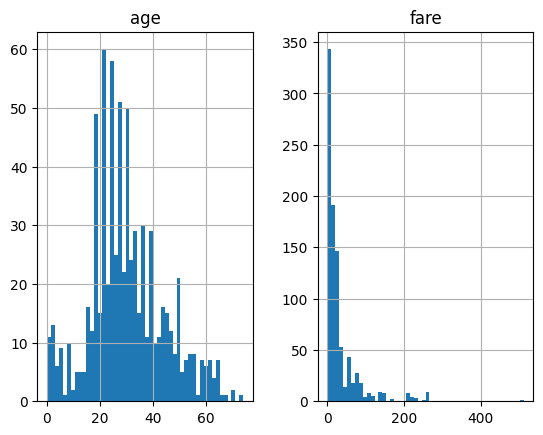

In [6]:
# let's explore the distribution of the variables
# to decide which arbitrary value to use

X_train.hist(bins=50)
plt.show()

In [7]:
# For this demo I will replace NA by 2 different arbitrary values
# one at the far right end of the distribution ==> 99
# and alternatively by -1, taking advantage that Age takes only positive values

# first replace with 99
X_train['Age_99'] = X_train['age'].fillna(99)

# now replace with -1
X_train['Age_minus1'] = X_train['age'].fillna(-1)

X_train.head(15)

,age,fare,Age_99,Age_minus1
501,13.0,19.5000,13.0,13.0
588,4.0,23.0000,4.0,4.0
402,30.0,13.8583,30.0,30.0
1193,NaN,7.7250,99.0,-1.0
686,22.0,7.7250,22.0,22.0
971,NaN,7.8792,99.0,-1.0
117,30.0,56.9292,30.0,30.0
540,2.0,26.0000,2.0,2.0
294,49.0,110.8833,49.0,49.0
261,35.0,26.2875,35.0,35.0


Look at the rows with missing data (NaN) in Age, and see how in the new variables those were replaced by either 99 or -1.

In [8]:
# we can see a change in the variance after arbitrary value imputation
# this is expected, because the percentage of missing data is quite
# high in Age ~20%

print('Original variable variance: ', X_train['age'].var())
print('Variance after 99 imputation: ', X_train['Age_99'].var())
print('Variance after -1 imputation: ', X_train['Age_minus1'].var())

Original variable variance:  194.16304666581863
Variance after 99 imputation:  888.7051993280913
Variance after -1 imputation:  307.94005269387753


In fact, the effect on the variance will also be driven by the magnitude of the arbitrary value selected for the imputation, compare 99 with -1.

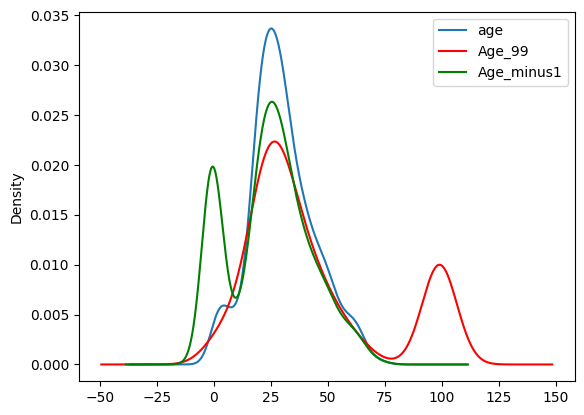

In [9]:
# we can see that the distribution has changed 
# with now more values accumulating towards the arbitrary values

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['age'].plot(kind='kde', ax=ax)

# variable imputed with 99
X_train['Age_99'].plot(kind='kde', ax=ax, color='red')

# variable imputed with -1
X_train['Age_minus1'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

As mentioned above, arbitrary value imputation distorts the original distribution of the variable Age. The transformed variable shows more values around arbitrary values.

**Is this important?**

It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. Arbitrary value imputation may distort the original normal distribution if the percentage of missing data is high. Therefore, the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

On the other hand, this technique works quite well with tree-based algorithms.

In [10]:
# we also said that arbitrary value imputation may affect the relationship 
# with the other variables in the dataset, let's have a look

X_train[['fare', 'age', 'Age_99', 'Age_minus1']].cov()

,fare,age,Age_99,Age_minus1
fare,2248.326729,136.176223,-38.722001,177.733891
age,136.176223,194.163047,194.163047,194.163047
Age_99,-38.722001,194.163047,888.705199,-175.265319
Age_minus1,177.733891,194.163047,-175.265319,307.940053


We see indeed that the covariance between Age and Fare is changed after the arbitrary value imputation.

<AxesSubplot: >

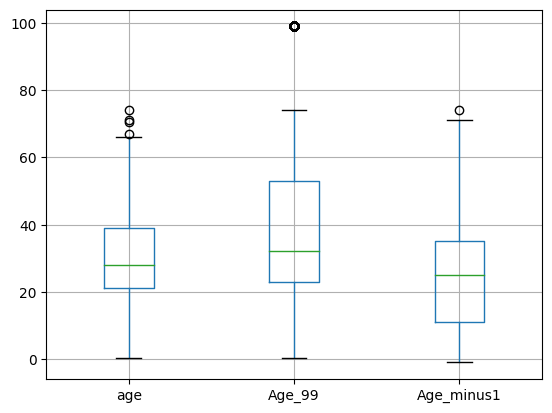

In [11]:
# Finally, I mentioned that arbitrary value imputation may
# affect the perception of outliers

# Let's find out using a boxplot
X_train[['age', 'Age_99', 'Age_minus1']].boxplot()

We can see that adding values at the end of the distribution mask entirely values that were outliers in the original distribution.

## House Prices Dataset

Let's repeat the exercise in the House Prices dataset. In this dataset, there are variables with a lot or few missing data. Therefore we can compare the effect of arbitrary value imputation in both scenarios.

In [12]:
# we are going to use only the following variables,
# 3 of which contain NA

cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [13]:
# let's load the House Prices dataset

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [14]:
# print the variables that contain missing data

# in the next list comprehension, I loop over all the columns 
# of the dataset and select those that contain missing data

[var for var in data.columns if data[var].isnull().sum()>0]

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [15]:
# find the percentage of missing data within those variables
# same code as we learnt in section 3 on variable characteristics

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

First, I separate into train and test.

In [16]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data,
    data['SalePrice'],
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((1022, 10), (438, 10))

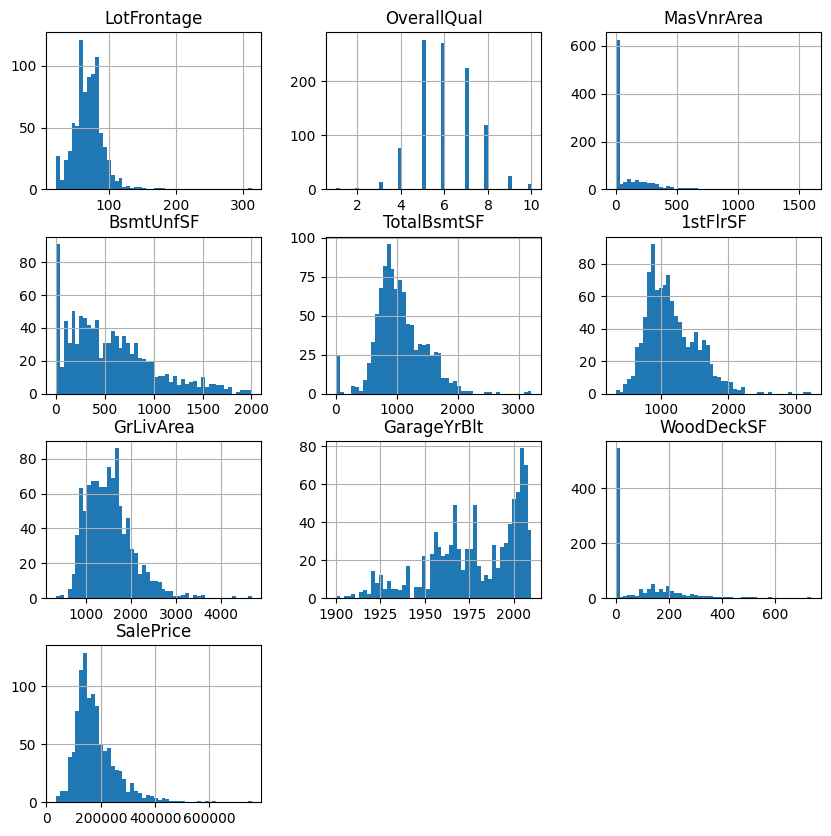

In [17]:
# let's plot the distributions of the variables
# we learnt this code in section 3 on variable characteristics

X_train.hist(bins=50, figsize=(10,10))
plt.show()

In [18]:
# Let's work with the variable LotFrontage first

# I create a new variable with the missing values replaced
# by 999 using the function we created above

# in this case I chose 999 to place the value at the far right end of the
# distribution. As we can see from the hist above, LotFrontAge takes values
# up to 300

X_train['LotFrontage_imputed'] = X_train['LotFrontage'].fillna(999)
X_test['LotFrontage_imputed'] = X_test['LotFrontage'].fillna(999)

In [19]:
# MasVnrArea takes values up to 1500, therefore, 999 will not
# work for this variable, as it is a normal value, I need to chose
# a bigger value: 2999

X_train.loc[:,'MasVnrArea_imputed'] = X_train['MasVnrArea'].fillna(2999)
X_test.loc[:,'MasVnrArea_imputed'] = X_test['MasVnrArea'].fillna(2999)

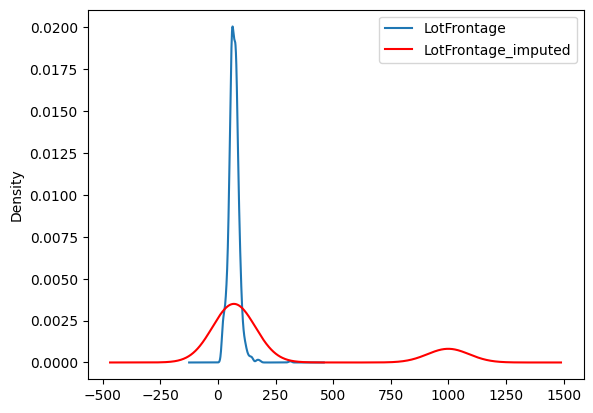

In [20]:
# let's evaluate the effect of arbitrary imputation on the distribution

# we can see that the distribution has changed for LotFrontAge
# with now more values accumulating towards 999

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# variable imputed with the 999
X_train['LotFrontage_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

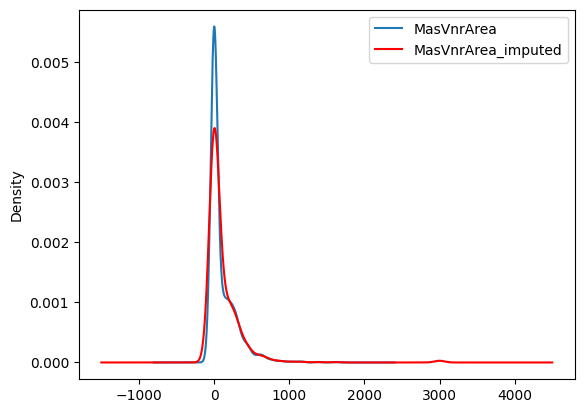

In [21]:
# For MasVnrArea, because the percentage of missing data
# was low, the change in the distribution is smaller

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['MasVnrArea'].plot(kind='kde', ax=ax)

# variable imputed with 2999
X_train['MasVnrArea_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

From the plots, we can see that the distribution of LotFrontAge has changed quite dramatically, but not so much the distribution of MasVnrArea. This is because the percentage of missing values in the second variable is quite small. However, the distribution will be impacted more or less depending on the arbitrary value you choose to replace the NA. 

Why don't you go ahead and try different numbers and compare the distributions?

Finally, you can see from the demo that the process of selecting the arbitrary value is quite manual. We need to go variable per variable, observe the distribution and min/max values, and then select the arbitrary value. It works well for a few variables, but if our datasets contain hundreds or thousands, it becomes a bit inconvenient. An alternative to automation is to place the values at the end of the distribution, as we will see in the next notebook.

In [22]:
# similarly we can explore the effect of the imputation technique on 
# the variance

# we can see a change in the variance after imputation for LotFrontAge
# this is expected, because the percentage of missing data is quite
# high ~20%

# in fact the effect is quite dramatic

print('Original Variance: ', X_train['LotFrontage'].var())
print('Variance after imputation: ', X_train['LotFrontage_imputed'].var())

Original Variance:  532.5872021885677
Variance after imputation:  130742.07296576205


In [23]:
# the same for MasnVnrArea, even though the % of NA is small, the
# arbitrary value is much bigger, which in turn affects the variance
# quite a bit

print('Original Variance: ', X_train['MasVnrArea'].var())
print('Variance after imputation: ', X_train['MasVnrArea_imputed'].var())

Original Variance:  32983.53871003956
Variance after imputation:  73677.0287993238


In [24]:
# finally, let's explore the covariance:
# take your time to compare the values in the table below.

X_train.cov()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice,LotFrontage_imputed,MasVnrArea_imputed
LotFrontage,532.587202,6.587119,6.805603e+02,9.496573e+02,2.908856e+03,3.379794e+03,3.919952e+03,30.611717,1.347414e+02,6.689645e+05,532.587202,7.585010e+02
OverallQual,6.587119,1.843859,1.014970e+02,1.746147e+02,2.886241e+02,2.242973e+02,4.091242e+02,17.902809,3.168557e+01,8.320132e+04,-18.279174,1.140556e+02
MasVnrArea,680.560330,101.496976,3.298354e+04,7.540788e+03,2.478877e+04,2.086595e+04,3.520785e+04,1203.583792,3.208924e+03,6.836439e+06,1582.711167,3.298354e+04
BsmtUnfSF,949.657293,174.614725,7.540788e+03,1.875241e+05,7.513307e+04,4.987449e+04,5.203392e+04,1823.065167,-1.833201e+03,6.833028e+06,-19005.620715,8.391605e+03
TotalBsmtSF,2908.855504,288.624075,2.478877e+04,7.513307e+04,1.682931e+05,1.212079e+05,8.615192e+04,3173.042442,1.227966e+04,2.003928e+07,1620.452017,2.503117e+04
1stFlrSF,3379.793504,224.297266,2.086595e+04,4.987449e+04,1.212079e+05,1.398656e+05,1.044401e+05,2009.195552,1.109406e+04,1.783631e+07,7485.021442,1.971276e+04
GrLivArea,3919.951834,409.124216,3.520785e+04,5.203392e+04,8.615192e+04,1.044401e+05,2.681277e+05,2738.982988,1.558395e+04,2.934477e+07,9634.034363,3.694487e+04
GarageYrBlt,30.611717,17.902809,1.203584e+03,1.823065e+03,3.173042e+03,2.009196e+03,2.738983e+03,624.305948,6.658911e+02,9.309355e+05,45.643154,1.588757e+03
WoodDeckSF,134.741376,31.685571,3.208924e+03,-1.833201e+03,1.227966e+04,1.109406e+04,1.558395e+04,665.891118,1.648582e+04,3.029981e+06,5377.154974,2.664993e+03
SalePrice,668964.454191,83201.317781,6.836439e+06,6.833028e+06,2.003928e+07,1.783631e+07,2.934477e+07,930935.489321,3.029981e+06,6.105731e+09,950743.964420,7.152962e+06


**That is all for this demonstration. In later sections I will show you how to do arbitrary value imputation with scikit-learn and feature engine.**